In [0]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data Preperation

In [0]:
#Loading of the csv s

path = '/content/drive/My Drive/DLMI/Data_challenge/'
output = pd.read_csv(path +"output_VSVxRFU.csv")

path_train = path +  "data_Q0G7b5t/"
clinical_data_train = pd.read_csv(path_train +"features/clinical_data.csv")
radiomics_train = pd.read_csv(path_train +"features/radiomics.csv")

path_test= path + "data_9Cbe5hx/"
clinical_data_test = pd.read_csv(path_test +"features/clinical_data.csv")
radiomics_test = pd.read_csv(path_test +"features/radiomics.csv")

radiomics_train.columns = ["PatientID"] + list(radiomics_train.iloc[0,1:])
radiomics_train = radiomics_train.iloc[2:,:]
radiomics_train = (radiomics_train).astype(float)

radiomics_test.columns = ["PatientID"] + list(radiomics_test.iloc[0,1:])
radiomics_test = radiomics_test.iloc[2:,:]
radiomics_test = (radiomics_test).astype(float)

clinical_data_train.set_index("PatientID", inplace=True)
clinical_data_test.set_index("PatientID", inplace=True)
radiomics_train.set_index("PatientID", inplace=True)
radiomics_test.set_index("PatientID", inplace=True)
output.set_index("PatientID",inplace=True)

submission_ex = pd.read_csv(path + "random_submission_0vhlEZN.csv")
submission_ex.set_index("PatientID", inplace=True)

## Analysing the data

In [0]:
def characteristics_table(df, merged_df,output):
    """Creates a DataFrame that summarizes the characteristics of the DataFrame df"""
    Histology = set(clinical_data_train['Histology'])
    population_df = pd.DataFrame(index=Histology,
                                columns=['Tstage','Mstage','Nstage', 'age','%l1','%l2','SurvivalTime','Event=0',"Event=1" 
                                         ])
    df = df.join(output,on='PatientID')
    merged_df = merged_df.join(output,on='PatientID')
    sub_merged_df = merged_df.loc[df.index]
    
    for Histology in population_df.index.values:
        if not pd.isna(Histology):
          Histology_df = sub_merged_df[df.Histology == Histology]
          population_df.loc[Histology, 'N'] = len(Histology_df)
          # Age
          mean_age = np.nanmean(Histology_df.age)
          std_age = np.nanstd(Histology_df.age)
          population_df.loc[Histology, 'age'] = '%.1f ± %.1f' % (mean_age, std_age)
          # l1
          population_df.loc[Histology, '%l1'] = round((len(Histology_df[Histology_df.SourceDataset == 'l1']) / len(Histology_df.SourceDataset)) * 100, 1)
          # l2
          population_df.loc[Histology, '%l2'] = round((len(Histology_df[Histology_df.SourceDataset == 'l2']) / len(Histology_df)) * 100, 1)
          # Tstage
          mean_Tstage= np.nanmean(Histology_df.Tstage)
          std_Tstage = np.nanstd(Histology_df.Tstage)
          population_df.loc[Histology, 'Tstage'] = '%.1f ± %.1f' % (mean_Tstage, std_Tstage)
          # Mstage
          mean_Mstage= np.nanmean(Histology_df.Mstage)
          std_Mstage = np.nanstd(Histology_df.Mstage)
          population_df.loc[Histology, 'Mstage'] = '%.1f ± %.1f' % (mean_Mstage, std_Mstage)
          # Nstage
          mean_Nstage= np.nanmean(Histology_df.Nstage)
          std_Nstage = np.nanstd(Histology_df.Nstage)
          population_df.loc[Histology, 'Nstage'] = '%.1f ± %.1f' % (mean_Nstage, std_Nstage)
          #Survival time
          mean_SurvivalTime= np.nanmean(Histology_df.SurvivalTime)
          std_SurvivalTime = np.nanstd(Histology_df.SurvivalTime)
          population_df.loc[Histology, 'SurvivalTime'] = '%.1f ± %.1f' % (mean_SurvivalTime, std_SurvivalTime)
          #Escape
          for value in ['0', '1',]:
            population_df.loc[Histology, 'Event=%s' % value] = len(Histology_df[Histology_df.Event == float(value)])

    population_df = population_df.dropna()
    return population_df


population_df = characteristics_table(clinical_data_train,clinical_data_train,output)
population_df

,Tstage,Mstage,Nstage,age,%l1,%l2,SurvivalTime,Event=0,Event=1,N
NSCLC NOS (not otherwise specified),2.0 ± 1.0,0.0 ± 0.0,1.0 ± 1.0,70.0 ± 6.0,0,100,1116.0 ± 797.0,0,2,2.0
large cell,2.5 ± 1.1,0.1 ± 0.5,1.8 ± 1.1,66.5 ± 10.3,100,0,638.9 ± 460.2,25,36,61.0
adenocarcinoma,2.2 ± 1.0,0.0 ± 0.0,1.8 ± 1.2,67.8 ± 9.1,100,0,484.8 ± 406.9,7,14,21.0
nos,2.3 ± 1.1,0.1 ± 0.5,1.3 ± 1.2,67.4 ± 10.7,100,0,584.1 ± 403.1,11,27,38.0
squamous cell carcinoma,2.5 ± 1.1,0.0 ± 0.0,0.9 ± 1.1,70.6 ± 8.9,100,0,561.3 ± 474.8,20,39,59.0
Squamous cell carcinoma,1.7 ± 0.9,0.0 ± 0.0,0.2 ± 0.6,72.3 ± 6.1,0,100,1396.0 ± 871.6,14,5,19.0
Adenocarcinoma,1.6 ± 0.8,0.0 ± 0.2,0.3 ± 0.7,69.5 ± 9.2,0,100,1408.8 ± 840.5,53,27,80.0


In [0]:
###
def characteristics_table(df, merged_df):
    """Creates a DataFrame that summarizes the characteristics of the DataFrame df"""
    Histology = set(clinical_data_train['Histology'])
    population_df = pd.DataFrame(index=Histology,
                                columns=['Tstage','Mstage','Nstage', 'age','%l1','%l2' 
                                         ])
    sub_merged_df = merged_df.loc[df.index]
    
    for Histology in population_df.index.values:
        if not pd.isna(Histology):
          Histology_df = sub_merged_df[df.Histology == Histology]
          population_df.loc[Histology, 'N'] = len(Histology_df)
          # Age
          mean_age = np.nanmean(Histology_df.age)
          std_age = np.nanstd(Histology_df.age)
          population_df.loc[Histology, 'age'] = '%.1f ± %.1f' % (mean_age, std_age)
          # l1
          population_df.loc[Histology, '%l1'] = round((len(Histology_df[Histology_df.SourceDataset == 'l1']) / len(Histology_df.SourceDataset)) * 100, 1)
          # l2
          population_df.loc[Histology, '%l2'] = round((len(Histology_df[Histology_df.SourceDataset == 'l2']) / len(Histology_df)) * 100, 1)
          # Tstage
          mean_Tstage= np.nanmean(Histology_df.Tstage)
          std_Tstage = np.nanstd(Histology_df.Tstage)
          population_df.loc[Histology, 'Tstage'] = '%.1f ± %.1f' % (mean_Tstage, std_Tstage)
          # Mstage
          mean_Mstage= np.nanmean(Histology_df.Mstage)
          std_Mstage = np.nanstd(Histology_df.Mstage)
          population_df.loc[Histology, 'Mstage'] = '%.1f ± %.1f' % (mean_Mstage, std_Mstage)
          # Nstage
          mean_Nstage= np.nanmean(Histology_df.Nstage)
          std_Nstage = np.nanstd(Histology_df.Nstage)
          population_df.loc[Histology, 'Nstage'] = '%.1f ± %.1f' % (mean_Nstage, std_Nstage)

    population_df = population_df.dropna()
    return population_df

population_df = characteristics_table(clinical_data_test,clinical_data_test)
print("For this dataset we don't have the output as we have to figure it out")
population_df

For this dataset we don't have the output as we have to figure it out


,Tstage,Mstage,Nstage,age,%l1,%l2,N
NSCLC NOS (not otherwise specified),4.0 ± 0.0,0.0 ± 0.0,0.0 ± 0.0,76.0 ± 0.0,0,100,1.0
large cell,2.8 ± 1.2,0.0 ± 0.0,1.6 ± 1.3,67.6 ± 10.0,100,0,32.0
adenocarcinoma,1.8 ± 1.2,0.0 ± 0.0,1.8 ± 1.0,69.8 ± 6.1,100,0,5.0
nos,2.4 ± 1.0,0.0 ± 0.0,1.5 ± 1.3,60.7 ± 7.8,100,0,13.0
squamous cell carcinoma,2.7 ± 0.9,0.0 ± 0.0,1.7 ± 1.3,70.7 ± 11.6,100,0,23.0
Squamous cell carcinoma,1.6 ± 0.7,0.0 ± 0.0,0.4 ± 0.7,70.2 ± 4.4,0,100,8.0
Adenocarcinoma,1.7 ± 0.8,0.1 ± 0.2,0.3 ± 0.6,66.6 ± 9.5,0,100,31.0


In [0]:
#Path images train et test 
Path_image_train = path + "data_Q0G7b5t/images/"
Path_image_test = path + "data_9Cbe5hx/images/"

shape of scan is (92, 92, 92)
shape of mask is (92, 92, 92)


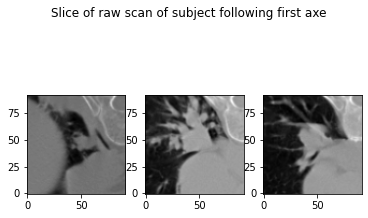

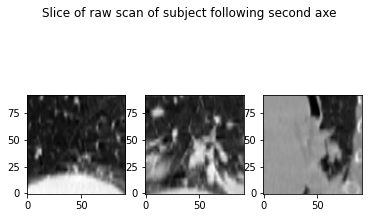

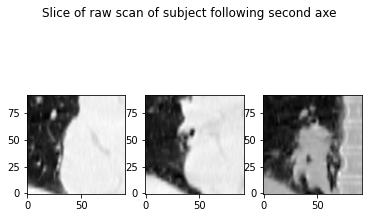

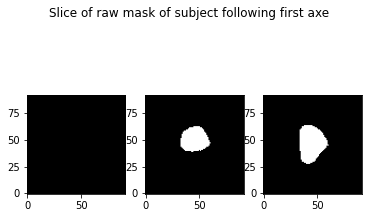

In [0]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

ex_archive = np.load(Path_image_train + 'patient_020.npz')
scan = ex_archive['scan']
mask = ex_archive['mask']

# scan.shape equals mask.shape

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")


print("shape of scan is " + str(scan.shape))
print("shape of mask is " + str(mask.shape))

slice_0 = scan[ :,:,1]
slice_1 = scan[ :,:,30]
slice_2 = scan[ :,:,60]
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw scan of subject following first axe")
plt.show()

slice_0 = scan[ 1,:,:]
slice_1 = scan[ 30,:,:]
slice_2 = scan[ 60,:,:]
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw scan of subject following second axe")
plt.show()


slice_0 = scan[ :,1,:]
slice_1 = scan[ :,30,:]
slice_2 = scan[ :,60,:]
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw scan of subject following second axe")
plt.show()


slice_0 = mask[ :,:,1]
slice_1 = mask[ :,:,30]
slice_2 = mask[ :,:,60]
show_slices([slice_0,slice_1,slice_2])
plt.suptitle("Slice of raw mask of subject following first axe")
plt.show()


## Preparing Data Loaders

In [0]:
#Path images train et test 
Path_image_train = path + "data_Q0G7b5t/images/"
Path_image_test = path + "data_9Cbe5hx/images/"

In [0]:
from torch.utils.data import Dataset, DataLoader, sampler

class OurDataset_train(Dataset):
    """This dataset includes .... """
    
    def __init__(self, img_dir, clinical_data,radiomics, output, transform=None):
        """
        Args:
            img_dir: (str) path to the images directory.
            clinical_data: (DataFrame) list of subjects with clinical data.
            radiomics: (DataFrame) list of subjects with 53 features on each.
            transform: Optional, transformations applied to ...
        """
        self.img_dir = img_dir
        self.radiomics = radiomics
        self.clinical_data = clinical_data
        self.transform = transform
        
        self.clinical_data = self.clinical_data.join(output,on='PatientID')
        self.clinical_data = self.clinical_data.reset_index()

        self.size = self[0]['scan'].shape
        
    def __len__(self):
        return len(self.clinical_data)

    def __getitem__(self, idx):
        """
        Args:
            idx: (int) the index of the subject/session whom data is loaded.
        Returns:
            sample: (dict) corresponding data described by the following keys:
                scan: 
                mask: 
                PatientID: 
                SourceDataset	
        """
        PatientID = self.clinical_data.loc[idx, 'PatientID']
        str_PID = str(PatientID)
        if len(str_PID) ==1:
          str_PID = "00"+str_PID
        elif len(str_PID) ==2:
          str_PID = "0"+str_PID

        SourceDataset = self.clinical_data.loc[idx, 'SourceDataset']


        filename = "patient_"+ str_PID + ".npz"
        with np.load(self.img_dir + filename) as image:
            scan = torch.from_numpy(image['scan']).type(torch.FloatTensor)
            scan = scan.permute(2,1,0)
            mask = torch.from_numpy(image['mask']).type(torch.FloatTensor)
            mask = mask.permute(2,1,0)
        SurvivalTime = self.clinical_data.loc[idx, 'SurvivalTime'].astype(np.long)
        
        if self.transform:
            scan = self.transform(scan)

        sample = {'scan': scan, 'mask': mask,
                  'PatientID': PatientID,
                  'SurvivalTime' : SurvivalTime,
                  'SourceDataset': SourceDataset}
        return sample

    def train(self):
        """Put all the transforms of the dataset in training mode"""
        self.transform.train()

    def eval(self):
        """Put all the transforms of the dataset in evaluation mode"""
        self.transform.eval()

class OurDataset_test(Dataset):
    """This dataset includes .... """
    
    def __init__(self, img_dir, clinical_data,radiomics, transform=None):
        """
        Args:
            img_dir: (str) path to the images directory.
            clinical_data: (DataFrame) list of subjects with clinical data.
            radiomics: (DataFrame) list of subjects with 53 features on each.
            transform: Optional, transformations applied to ...
        """
        self.img_dir = img_dir
        self.radiomics = radiomics
        self.clinical_data = clinical_data
        self.transform = transform
        
        self.clinical_data = self.clinical_data.reset_index()
        #self.clinical_data = self.clinical_data.reset_index()

        self.size = self[0]['scan'].shape
        
    def __len__(self):
        return len(self.clinical_data)

    def __getitem__(self, idx):

        PatientID = self.clinical_data.loc[idx, 'PatientID']
        str_PID = str(PatientID)
        if len(str_PID) ==1:
          str_PID = "00"+str_PID
        elif len(str_PID) ==2:
          str_PID = "0"+str_PID

        SourceDataset = self.clinical_data.loc[idx, 'SourceDataset']

        filename = "patient_"+ str_PID + ".npz"
        with np.load(self.img_dir + filename) as image:
            scan = torch.from_numpy(image['scan']).type(torch.FloatTensor)#.unsqueeze(0)
            scan = scan.permute(2,1,0)
            mask = torch.from_numpy(image['mask']).type(torch.FloatTensor)#.unsqueeze(0)
            mask = mask.permute(2,1,0)
        
        if self.transform:
            scan = self.transform(scan)

        sample = {'scan': scan, 'mask': mask,
                  'PatientID': PatientID,
                  'SourceDataset': SourceDataset}
        return sample

    def train(self):
        """Put all the transforms of the dataset in training mode"""
        self.transform.train()

    def eval(self):
        """Put all the transforms of the dataset in evaluation mode"""
        self.transform.eval()

class OurDataset_all(Dataset):
    
    def __init__(self, img_dir, clinical_data, radiomics, transform=None):

        self.img_dir = img_dir
        self.radiomics = radiomics
        self.clinical_data = clinical_data
        self.transform = transform
        
        self.clinical_data = self.clinical_data.reset_index()

        self.size = self[0]['scan'].shape
        
    def __len__(self):
        return len(self.clinical_data)

    def __getitem__(self, idx):

        PatientID = self.clinical_data.loc[idx, 'PatientID']
        str_PID = str(PatientID)
        if len(str_PID) ==1:
          str_PID = "00"+str_PID
        elif len(str_PID) ==2:
          str_PID = "0"+str_PID

        SourceDataset = self.clinical_data.loc[idx, 'SourceDataset']


        filename = "patient_"+ str_PID + ".npz"
        with np.load(self.img_dir + filename) as image:
            scan = torch.from_numpy(image['scan']).type(torch.FloatTensor)#.unsqueeze(0)
            scan = scan.permute(2,1,0)
            mask = torch.from_numpy(image['mask']).type(torch.FloatTensor)#.unsqueeze(0)
            mask = mask.permute(2,1,0)
        if self.transform:
            scan = self.transform(scan)

        sample = {'scan': scan, 'mask': mask,
                  'PatientID': PatientID,
                  'SourceDataset': SourceDataset}
        return sample

In [0]:
batch_size=1

example_dataset = OurDataset_train(Path_image_train, clinical_data_train,radiomics_train,output,transform=None)
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)

for data in example_dataloader:
    print(data['SurvivalTime'])
    break

print("Shape of Dataset output\n", example_dataset[0]['scan'].shape)
print()
print("Shape of DataLoader output\n", data['scan'].squeeze().shape)

tensor([1378])
Shape of Dataset output
 torch.Size([92, 92, 92])

Shape of DataLoader output
 torch.Size([92, 92, 92])


## Building the model

In [0]:
def get_activation(activation_type):
    activation_type = activation_type.lower()
    if hasattr(nn, activation_type):
      return getattr(nn, activation_type)()
    else:
      return nn.ReLU()

def _make_nConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
  layers = []
  layers.append(ConvBatchNorm(in_channels, out_channels, activation))

  for _ in range(nb_Conv-1):
      layers.append(ConvBatchNorm(out_channels, out_channels, activation))
  return nn.Sequential(*layers)

class ConvBatchNorm(nn.Module):
  """(convolution => [BN] => ReLU)"""
  
  def __init__(self, in_channels, out_channels, activation='ReLU'):
    super(ConvBatchNorm, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, 
                          kernel_size=3, padding=1)
    self.norm = nn.BatchNorm2d(out_channels)
    self.activation = get_activation(activation)
      
  def forward(self, x):
    out = self.conv(x)
    out = self.norm(out)
    return self.activation(out)

class DownBlock(nn.Module):
  """Downscaling with maxpool convolution"""

  def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
    super(DownBlock, self).__init__()
    self.maxpool = nn.MaxPool2d(2)
    self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)
        
  def forward(self, x):
    out = self.maxpool(x)
    return self.nConvs(out)  

class UpBlock(nn.Module):
  """Upscaling then conv"""

  def __init__(self, in_channels, out_channels, nb_Conv, in_padding=0, out_padding=1, activation='ReLU'):
    super(UpBlock, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2,\
                                 padding=in_padding, output_padding=out_padding)
    self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

  def forward(self, x, skip_x):
    out = self.up(x)
    x = torch.cat([out, skip_x], dim=1) 
    return self.nConvs(x)

In [0]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes):
    '''
    n_channels : number of channels of the input. 
                    By default 4, because we have 4 modalities
    n_labels : number of channels of the ouput.
                  By default 4 (3 labels + 1 for the background)
    '''
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.inc = ConvBatchNorm(n_channels, 64)
    self.down1 = DownBlock(64, 128, nb_Conv=2)
    self.down2 = DownBlock(128, 256, nb_Conv=2)
    self.down3 = DownBlock(256, 512, nb_Conv=2)
    self.down4 = DownBlock(512, 512, nb_Conv=2)
    self.up1 = UpBlock(512+512, 512, nb_Conv=2, in_padding=0)
    self.up2 = UpBlock(512+256, 256, nb_Conv=2)
    self.up3 = UpBlock(256+128, 128, nb_Conv=2, in_padding=0, out_padding=0)
    self.up4 = UpBlock(128+64, 64, nb_Conv=2, in_padding=0, out_padding=0)
    self.outc = nn.Conv2d(64, n_classes, kernel_size=3, stride=1, padding=1)
    self.last_activation = get_activation('Sigmoid')

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.last_activation(self.outc(x))
    return logits

In [0]:
model = UNet(n_channels=92, n_classes=92)


# Image of size 96*96 with 4 modality + batch size = 1
x = torch.from_numpy(np.random.randn(1, 92, 92, 92)).float()
y = model(x)
print(y.shape)

torch.Size([1, 92, 92, 92])


In [0]:
def train(model, train_loader, criterion, optimizer, n_epochs):
    """
    Method used to train a CNN
    
    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping the dataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training

    Returns:
        best_model: (nn.Module) the trained neural network
    """
    best_model = deepcopy(model)
    train_best_loss = np.inf
    batch_size = train_loader.batch_size
    n = train_loader.dataset.clinical_data.shape[0]

    n_batches = n//batch_size

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        t0 = time()
        for i, data in enumerate(train_loader):
            images, masks = data['scan'], data['mask']
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), masks.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / len(train_loader.dataset)
        print('Epoch %i: loss = %f' % (epoch+1, mean_loss))

        if mean_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = mean_loss
    
    return best_model

def test(model, data_loader, criterion):
    """
    Method used to test a CNN
    
    Args:
        model: (nn.Module) the neural network
        data_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
    
    Returns:
        results_df: (DataFrame) the label predicted for on the slice level.
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    columns = ["participant_id", "slice_id", "proba0", "proba1",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    batch_size = data_loader.batch_size
    n = data_loader.dataset.clinical_data.shape[0]

    n_batches = n//batch_size
    
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, masks = data['scan'], data['mask'] #unsqueeze(1)
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            print("Batch {}/{} loss : {}".format(i+1, n_batches, str(total_loss/((i+1)*batch_size))))

    print("Final loss : {}".format(str(total_loss/ len(data_loader.dataset))))


def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))
    
    metrics_dict = dict()
    metrics_dict['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sensitivity'] = tp / (tp + fn)
    else:
        metrics_dict['sensitivity'] = 0.0
        
    # Specificity
    if fp + tn != 0:
        metrics_dict['specificity'] = tn / (fp + tn)
    else:
        metrics_dict['specificity'] = 0.0
        
    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    
    return metrics_dict

In [0]:
def dice_loss(input, target):
    smooth = 1.
    target = target.float()
    input = input.float()
    input_flat = input.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (input_flat * target_flat).sum()
    return 1 - ((2. * intersection + smooth)/(input_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth))

def mean_dice_loss(input, target):
  
  channels = list(range(target.shape[1]))
  loss = 0
  for channel in channels:
    dice = dice_loss(input[:, channel, ...],
                     target[:, channel, ...])
    loss += dice

  return loss / len(channels)

## Validating the model


In [0]:
from sklearn.model_selection import train_test_split

idx = [i for i in range(len(clinical_data_train))]
idx_train, idx_val= train_test_split(idx,test_size = 0.2, random_state=42)

clinical_data_for_train = clinical_data_train.iloc[idx_train]
clinical_data_for_val = clinical_data_train.iloc[idx_val]

radiomics_for_train = radiomics_train.iloc[idx_train]
radiomics_for_val = radiomics_train.iloc[idx_val]

output_for_train = output.iloc[idx_train]
output_for_val = output.iloc[idx_val]

batch_size=5
dataset_train = OurDataset_train(Path_image_train, clinical_data_for_train, radiomics_for_train, output_for_train, transform=None)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, drop_last=True)

dataset_val = OurDataset_train(Path_image_train, clinical_data_for_val, radiomics_for_val,output_for_val, transform=None)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, drop_last=True)

In [0]:
learning_rate = 1e-4

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
n_epochs = 15

model = train(model, dataloader_train, criterion, optimizer, n_epochs)

Epoch 1: loss = 0.005543
Epoch 2: loss = 0.005303
Epoch 3: loss = 0.005242
Epoch 4: loss = 0.005048
Epoch 5: loss = 0.004929
Epoch 6: loss = 0.004730
Epoch 7: loss = 0.004679
Epoch 8: loss = 0.004604
Epoch 9: loss = 0.004564
Epoch 10: loss = 0.004378
Epoch 11: loss = 0.004309
Epoch 12: loss = 0.004297
Epoch 13: loss = 0.004238
Epoch 14: loss = 0.004161
Epoch 15: loss = 0.004121


In [0]:
test(model, dataloader_val, criterion)

Batch 1/12 loss : 0.027243173122406004
Batch 2/12 loss : 0.024075818061828614
Batch 3/12 loss : 0.02457034190495809
Batch 4/12 loss : 0.02436426281929016
Batch 5/12 loss : 0.02389596462249756
Batch 6/12 loss : 0.023368197679519653
Batch 7/12 loss : 0.023987512929098946
Batch 8/12 loss : 0.022940579056739806
Batch 9/12 loss : 0.022472508748372397
Batch 10/12 loss : 0.02293136477470398
Batch 11/12 loss : 0.02303732308474454
Batch 12/12 loss : 0.022854134440422058
Final loss : 0.022854134440422058


## Making predictions and comparing with the ground truth

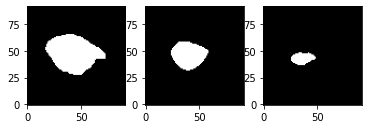

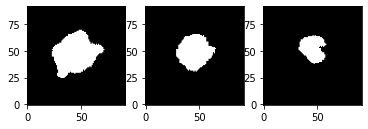

In [0]:
ex_archive = np.load(Path_image_train + 'patient_044.npz')
scan = ex_archive['scan']
mask = ex_archive['mask']

example_mask = model(torch.from_numpy(scan).unsqueeze(0).type(torch.cuda.FloatTensor))

slice_10_pred = example_mask.cpu().detach().numpy()[0,50,:,:].T
slice_40_pred = example_mask.cpu().detach().numpy()[0,60,:,:].T
slice_70_pred = example_mask.cpu().detach().numpy()[0,70,:,:].T

slice_10_pred = (slice_10_pred>0.7).astype(float)
slice_40_pred = (slice_40_pred>0.7).astype(float)
slice_70_pred = (slice_70_pred>0.7).astype(float)

mask_10 = mask[:,:,50]
mask_40 = mask[:,:,60]
mask_70 = mask[:,:,70]

show_slices([mask_10,mask_40,mask_70])
show_slices([slice_10_pred,slice_40_pred,slice_70_pred])

## Training on all the data

In [0]:
clinical_data_all = clinical_data_train.append(clinical_data_test)


radiomics_all = radiomics_train.append(radiomics_test)

Path_image_all = path + 'data_all/images/'

batch_size=5

dataset_all = OurDataset_all(Path_image_all, clinical_data_all, radiomics_all, transform=None)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, drop_last=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = UNet(n_channels=92, n_classes=92)

model.to(device)

learning_rate = 1e-6

#criterion = mean_dice_loss
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

n_epochs = 200

model = train(model, dataloader_all, criterion, optimizer, n_epochs)

In [0]:
torch.save(new_model.state_dict(), 'model_v6.pt')

## Loading model

In [0]:
model_path = '/content/drive/My Drive/DLMI/unet 2d/model_v5.pt'
model = UNet(n_channels=92, n_classes=92)

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

## Creating features

In [0]:
class Encoder(nn.Module):
  def __init__(self, model):
    super(Encoder, self).__init__()
    layers = []
    layers.append(model.inc)
    layers.append(model.down1)
    layers.append(model.down2)
    layers.append(model.down3)
    layers.append(model.down4)
    layers.append(nn.Flatten())
    self.encoder = nn.Sequential(*layers)

  def forward(self, x):
    return self.encoder(x)

In [0]:
encoder = Encoder(model)

In [0]:
def encode(encoder, loader):
  df = pd.DataFrame()
  for data in loader:
    images, masks = data['scan'], data['mask']
    images, masks = images.cuda(), masks.cuda()
    features = encoder(images)
    features = features.detach().cpu().numpy()
    df = df.append(pd.DataFrame(features))
  return df

In [0]:
dataset_all_train = OurDataset_train(Path_image_train, clinical_data_train, radiomics_train,output, transform=None)
dataloader_all_train = DataLoader(dataset_all_train, batch_size=batch_size, drop_last=True)

df_encoded_train = encode(encoder, dataloader_all_train)

In [0]:
dataset_all_test = OurDataset_test(Path_image_test, clinical_data_test, radiomics_test, transform=None)
dataloader_all_test = DataLoader(dataset_all_test, batch_size=batch_size, drop_last=False)

df_encoded_test = encode(encoder, dataloader_all_test)

In [0]:
df_encoded_train.to_csv("features_train_v6.csv")
df_encoded_test.to_csv("features_test_v6.csv")
!cp -t '/content/drive/My Drive/DLMI/unet 2d' features_train_v6.csv
!cp -t '/content/drive/My Drive/DLMI/unet 2d' features_test_v6.csv

## Model engineering

In [0]:
!pip install catboost
!pip install https://github.com/scikit-learn-contrib/scikit-learn-extra/archive/master.zip

     |████████████████████████████████| 64.4MB 71kB/s 
     \ 1.3MB 1.8MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for sklearn-extra: filename=sklearn_extra-0.0.3-cp36-cp36m-linux_x86_64.whl size=346265 sha256=1f747a96985779ccf1104a17b623c626517172bf00b3f9032a11364cf8441dfa
  Stored in directory: /tmp/pip-ephem-wheel-cache-kvgk_ypn/wheels/d3/a5/a8/411bc2d0939f2cc9d17f34f0d3457043c68e14a98b91fd8301
Successfully built sklearn-extra


In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import warnings
import seaborn as sns

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from sklearn.cluster import FeatureAgglomeration
import itertools

In [0]:
# the score function

def cindex(y_true_times, predicted_times, tol=1e-8):
    """
    Author: Romuald Menuet & Rémy Dubois

    Evaluate concordance index from Pandas DataFrame, taking ties into account.

    Args:
        y_true_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `Event` and `SurvivalTime` the float-valued column of true survival times.
        predicted_times: pd.DataFrame
            pd DataFrame with three columns: `PatientID`, `SurvivalTime` the float-valued column of predicted survival times,
            and one `Event`column, whose value does not matter. It must be appended so that target and predictions have the same format.
        tol: float
            small float value for numerical stability.
    Returns:
        Concordance index, as described here:
        https://square.github.io/pysurvival/metrics/c_index.html
    """

    assert isinstance(y_true_times, pd.DataFrame), 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert isinstance(predicted_times, pd.DataFrame), 'Predicted times should be pd dataframe with patient `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(y_true_times.shape) == 2, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert len(predicted_times.shape) == 2, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(y_true_times.columns) == {'Event', 'SurvivalTime'}, 'Y true times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    assert set(predicted_times.columns) == {'Event', 'SurvivalTime'}, 'Predicted times should be pd dataframe with `PatientID` as index, and `Event` and `SurvivalTime` as columns'
    np.testing.assert_equal(y_true_times.shape, predicted_times.shape, err_msg="Not same amount of predicted versus true samples")
    assert set(y_true_times.index) == set(predicted_times.index), 'Not same patients in prediction versus ground truth'
    assert np.all(predicted_times['SurvivalTime'] > 0), 'Predicted times should all be positive'

    events = y_true_times.Event
    y_true_times = y_true_times.SurvivalTime
    predicted_times = predicted_times.SurvivalTime

    # Just ordering the right way
    predicted_times = predicted_times.loc[y_true_times.index]
    events = events.loc[y_true_times.index]

    events = events.values.astype(int)
    y_true_times = y_true_times.values.astype(float)
    predicted_times = predicted_times.values.astype(float)

    np.testing.assert_array_less(1.,
                                 predicted_times.astype(float),
                                 err_msg="Predicted y_true_times all below 1.\
                                 It should be in days. Make sure that you are not predicting risk instead of time.")

    return _cindex_np(y_true_times, predicted_times, events)


def _cindex_np(times, predicted_times, events, tol=1.e-8):
    """
    Raw CI computation from np arrray. Should not be used as is.
    """
    assert times.ndim == predicted_times.ndim == events.ndim == 1, "wrong input, should be vectors only"
    assert times.shape[0] == predicted_times.shape[0] == events.shape[0], "wrong input, should be vectors of the same len"

    risks = - predicted_times

    risks_i = risks.reshape((-1, 1))
    risks_j = risks.reshape((1, -1))
    times_i = times.reshape((-1, 1))
    times_j = times.reshape((1, -1))
    events_i = events.reshape((-1, 1))

    eligible_pairs = (times_i < times_j) * events_i

    well_ordered = np.sum(eligible_pairs * (risks_i > risks_j))
    ties = + np.sum(eligible_pairs * 0.5 * (risks_i == risks_j))

    return (well_ordered + ties) / (eligible_pairs.sum() + tol)

In [0]:
df_encoded_train = pd.read_csv('/content/drive/My Drive/DLMI/unet 2d/features_train_v5.csv').iloc[:,1:]
df_encoded_test = pd.read_csv('/content/drive/My Drive/DLMI/unet 2d/features_test_v5.csv').iloc[:,1:]

In [0]:
def train_model_and_validate_catboost(parameters, df_train_all, output):

  kfold = KFold(n_splits = 5, shuffle=True)
  iterations = parameters['iterations']
  lr = parameters['l_rate']
  depth = parameters['depth']
  l2_reg = parameters['l2']

  score = 0

  for train_ind, test_ind in kfold.split(df_train_all):

    x_train, x_val = df_train_all.iloc[train_ind], df_train_all.iloc[test_ind]
    y_train, y_val = output.iloc[train_ind], output.iloc[test_ind]

    model = CatBoostRegressor(iterations=iterations, learning_rate=lr,\
                              depth=depth, l2_leaf_reg=l2_reg)

    model.fit(x_train, y_train["SurvivalTime"], verbose=0)

    y_test_survivaltime = model.predict(x_val)
    y_test_survivaltime = np.clip(y_test_survivaltime, 0, np.inf)

    y_predicted = pd.DataFrame({'SurvivalTime':y_test_survivaltime, 'Event':y_val.Event}, index = y_val.index)

    score += cindex(y_val, y_predicted)
 
  return score/5

In [0]:
def train_model_and_validate_xgb(parameters, df_train_all, output):

  kfold = KFold(n_splits = 5)

  iterations = parameters['iterations']
  lr = parameters['l_rate']
  depth = parameters['depth']
  l1 = parameters['l1_reg']
  l2 = parameters['l2_reg']

  score = 0

  for train_ind, test_ind in kfold.split(df_train_all):

    x_train, x_val = df_train_all.iloc[train_ind], df_train_all.iloc[test_ind]
    y_train, y_val = output.iloc[train_ind], output.iloc[test_ind]

    model = XGBRegressor(n_estimators=iterations,max_depth=depth, learning_rate=lr,
                         reg_alpha = l1, reg_lambda = l2, verbosity=0)

    model.fit(x_train, y_train["SurvivalTime"], verbose=0)

    y_test_survivaltime = model.predict(x_val)
    y_test_survivaltime = np.clip(y_test_survivaltime, 0, np.inf)

    y_predicted = pd.DataFrame({'SurvivalTime':y_test_survivaltime, 'Event':y_val.Event}, index = y_val.index)

    score += cindex(y_val, y_predicted)
 
  return score/5

### Evaluating the U-NET features performance

In [0]:
le  = LabelEncoder()
clinical_encoded_train = clinical_data_train[:]
clinical_encoded_test = clinical_data_test[:]

clinical_encoded_train['Histology'] = le.fit_transform(clinical_encoded_train['Histology'].astype(str).values)
clinical_encoded_test['Histology'] = le.transform(clinical_encoded_test['Histology'].astype(str).values)

le  = LabelEncoder()
clinical_encoded_train['SourceDataset'] = le.fit_transform(clinical_encoded_train['SourceDataset'].astype(str).values)
clinical_encoded_test['SourceDataset'] = le.transform(clinical_encoded_test['SourceDataset'].astype(str).values)

In [0]:
cindex_radiomic = []
cindex_clinical = []
cindex_features = []

n_pca = 10

pca = PCA(n_pca)

scaler = StandardScaler()

df_train_scaled = scaler.fit_transform(df_encoded_train)

df_train_pca = pca.fit_transform(df_train_scaled)

df_train_pca = pd.DataFrame(df_train_pca)
df_train_pca.index = radiomics_train.index

iterr = 72
lr = 0.027
depth = 3
l1 = 162
l2 = 10.5
params = {'iterations':iterr, 'l_rate':lr, 'depth':depth, 'l2':l2}

for _ in range(30):
  
  score_radiomics = train_model_and_validate_catboost(params,  radiomics_train, output)
  score_clinical = train_model_and_validate_catboost(params,  clinical_encoded_train, output)
  score_features = train_model_and_validate_catboost(params,  df_train_pca, output)

  cindex_radiomic.append(score_radiomics)
  cindex_clinical.append(score_clinical)
  cindex_features.append(score_features)

final_result = pd.DataFrame({'radiomics':cindex_radiomic, 'clinical': cindex_clinical, 'features': cindex_features})

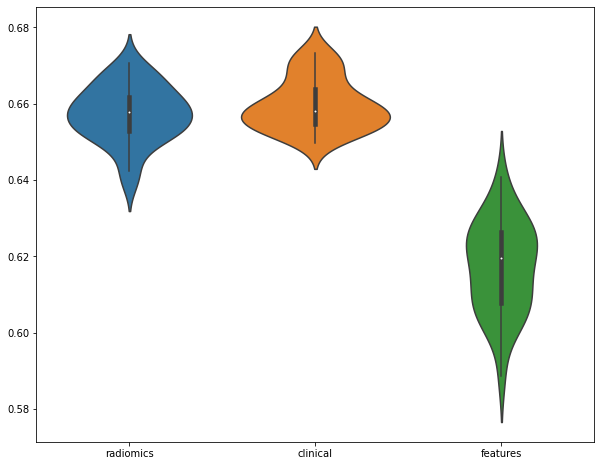

In [0]:
fig, ax = plt.subplots(figsize=(10,8))

sns.violinplot(data = final_result)

### First try with KMeans clustering

In [0]:
list_iterations = [100]
list_lr = [0.005]
list_depth = [3 ]
list_l2 = [0.6]
list_clusters = [100]

scaler = StandardScaler()

df_train_scaled = scaler.fit_transform(df_encoded_train)
df_test_scaled = scaler.transform(df_encoded_test)



df_score = pd.DataFrame(columns=['iterations', 'learning_rate', 'depth', 'l2_reg', 'n_clusters', 'score'])


for cluster in list_clusters:
  agglo = FeatureAgglomeration(n_clusters = cluster)

  agglo.fit(np.concatenate((df_train_scaled, df_test_scaled), axis=0))

  df_encoded_train_clustered = agglo.transform(df_train_scaled)
  df_encoded_test_clustered = agglo.transform(df_test_scaled)

  df_encoded_train_clustered = pd.DataFrame(df_encoded_train_clustered)
  df_encoded_train_clustered.index = radiomics_train.index
  df_encoded_test_clustered = pd.DataFrame(df_encoded_test_clustered)
  df_encoded_test_clustered.index = radiomics_test.index

  df_train_all = df_encoded_train_clustered.join(radiomics_train).join(clinical_data_train)
  df_test_all = df_encoded_test_clustered.join(radiomics_test).join(clinical_data_test)

  for iterr, lr, depth, l2 in itertools.product(list_iterations, list_lr, list_depth, list_l2):

    

    params = {'iterations':iterr,  'l_rate':lr, 'depth':depth, 'l2':l2}
    score = train_model_and_validate_catboost(params,  df_train_all, output)
    df_score = df_score.append([{'iterations':iterr,  'learning_rate':lr, 'depth':depth, 'l2_reg':l2, 'n_clusters':cluster , 'score':score}])
    print(score)

0.6622624310203886


In [0]:
df_score.sort_values(by=['score'], ascending=False).head(10)

,iterations,learning_rate,depth,l2_reg,n_clusters,score
0,100,0.005,3,0.6,100,0.673982
0,100,0.005,3,1.0,100,0.672630
0,120,0.005,3,0.6,100,0.672591
0,100,0.005,3,2.0,100,0.671182
0,80,0.005,3,0.6,100,0.671129
0,100,0.010,3,1.0,100,0.670694
0,80,0.005,3,1.0,100,0.670263
0,120,0.005,3,2.0,100,0.669570
0,120,0.005,3,1.0,100,0.669471
0,100,0.001,3,2.0,100,0.669264


In [0]:
df_score.groupby(['learning_rate']).mean()

,l2_reg,score
learning_rate,,
0.001,0.65,0.657259
0.005,0.65,0.665342
0.010,0.65,0.650531
0.020,0.65,0.664337


In [0]:
agglo = FeatureAgglomeration(n_clusters = 100)

agglo.fit(np.concatenate((df_train_scaled, df_test_scaled), axis=0))

df_encoded_train_clustered = agglo.transform(df_train_scaled)
df_encoded_test_clustered = agglo.transform(df_test_scaled)

df_encoded_train_clustered = pd.DataFrame(df_encoded_train_clustered)
df_encoded_train_clustered.index = radiomics_train.index
df_encoded_test_clustered = pd.DataFrame(df_encoded_test_clustered)
df_encoded_test_clustered.index = radiomics_test.index

df_train_all = df_encoded_train_clustered.join(radiomics_train).join(clinical_data_train)
df_test_all = df_encoded_test_clustered.join(radiomics_test).join(clinical_data_test)


model = CatBoostRegressor(iterations=100, learning_rate=0.005,\
                          depth=3, l2_leaf_reg=0.6)

model.fit(df_train_all, output["SurvivalTime"], verbose=0)

y_test = model.predict(df_test_all)

submission_ex["SurvivalTime"] = y_test
submission_ex.to_csv("submission_1.csv")

### Second try with PCA

In [0]:
list_iterations = [72]
list_lr = [0.027]
list_depth = [3]
list_l1 = [162]
list_l2 = [10.5]
list_pca = [10]

scaler = StandardScaler()

df_train_scaled = scaler.fit_transform(df_encoded_train)
df_test_scaled = scaler.transform(df_encoded_test)

df_score = pd.DataFrame(columns=['iterations', 'learning_rate', 'depth', 'l1_reg', 'l2_reg', 'n_pca', 'score'])

for n_pca in list_pca:


  pca = PCA(n_pca)

  df_train_pca = pca.fit_transform(df_train_scaled)
  df_test_pca = pca.transform(df_test_scaled)

  df_train_pca = pd.DataFrame(df_train_pca)
  df_train_pca.index = radiomics_train.index
  df_test_pca = pd.DataFrame(df_test_pca)
  df_test_pca.index = radiomics_test.index

  df_train_all = df_train_pca.join(radiomics_train).join(clinical_encoded_train)
  df_test_all = df_test_pca.join(radiomics_test).join(clinical_encoded_test)

  for iterr,  lr, depth, l1, l2 in itertools.product(list_iterations, list_lr, list_depth, list_l1, list_l2):


    params = {'iterations':iterr, 'l_rate':lr, 'depth':depth, 'l1_reg':l1, 'l2_reg':l2}
    score = train_model_and_validate_xgb(params,  df_train_all, output)
    df_score = df_score.append([{'iterations':iterr,  'learning_rate':lr, 'depth':depth, 'l1_reg':l1, 'l2_reg':l2, 'n_pca':n_pca, 'score':score}])
    print(score)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.6841222176962203


In [0]:
df_score.sort_values(by=['score'], ascending=False).head(20)

,iterations,learning_rate,depth,l1_reg,l2_reg,n_pca,score
0,72,0.027,3,162,10.5,10,0.684122


In [0]:
best_params_xgb = {'iterations':70,  'learning_rate':0.027, 'depth':3, 'l1_reg':162, 'l2_reg':10, 'n_pca':10}


scaler = StandardScaler()
pca = PCA(10)

df_train_scaled = scaler.fit_transform(df_encoded_train)
df_test_scaled = scaler.transform(df_encoded_test)

df_train_pca = pca.fit_transform(df_train_scaled)
df_test_pca = pca.transform(df_test_scaled)


df_train_pca = pd.DataFrame(df_train_pca)
df_train_pca.index = radiomics_train.index
df_test_pca = pd.DataFrame(df_test_pca)
df_test_pca.index = radiomics_test.index

df_train_all = df_train_pca.join(radiomics_train).join(clinical_encoded_train)
df_test_all = df_test_pca.join(radiomics_test).join(clinical_encoded_test)


model = XGBRegressor(n_estimators=70,max_depth=3, learning_rate=0.027,
                         reg_alpha = 162, reg_lambda = 10, verbosity=0)


model.fit(df_train_all, output["SurvivalTime"], verbose=0)

y_test = model.predict(df_test_all)

submission_ex["SurvivalTime"] = y_test
submission_ex.to_csv("submission_1.csv")

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
